In [15]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
                             roc_auc_score, confusion_matrix, roc_curve)

# XGBoost
from xgboost import XGBClassifier

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [16]:
# Cell 2: Load Data and Filter Features

# 1. Load the dataset
# Replace 'Kidney_stone_dataset.csv' with your specific file path if different
df = pd.read_csv('data/cleaned_stone.csv')

# 2. Define the strict feature set (The "Honest" List)
# We exclude 'hematuria', 'ana', 'months' as they are potential leakage/outcomes
honest_features = [
    'blood_pressure', 'water_intake', 'physical_activity', 'diet',
    'smoking', 'alcohol', 'painkiller_usage', 'family_history',
    'weight_changes', 'stress_level'
]

target = 'stone_risk'

# 3. Create Feature Matrix (X) and Target Vector (y)
X = df[honest_features].copy()
y = df[target].copy()

print(f"Original Dataset Shape: {df.shape}")
print(f"Filtered Feature Shape: {X.shape}")
print("-" * 30)
print("Final Features being used:", X.columns.tolist())

Original Dataset Shape: (4000, 24)
Filtered Feature Shape: (4000, 10)
------------------------------
Final Features being used: ['blood_pressure', 'water_intake', 'physical_activity', 'diet', 'smoking', 'alcohol', 'painkiller_usage', 'family_history', 'weight_changes', 'stress_level']


Target Distribution:
stone_risk
0    0.60825
1    0.39175
Name: proportion, dtype: float64


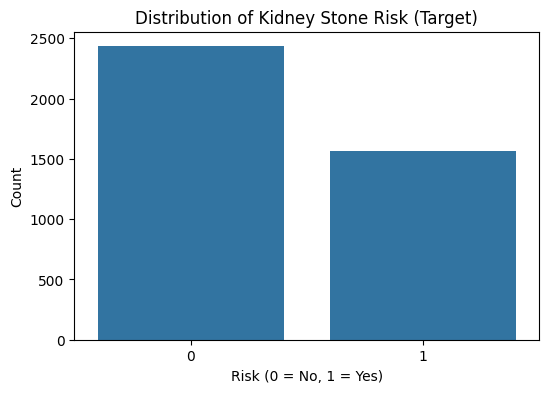


Numerical Features: ['blood_pressure', 'water_intake']
Categorical Features: ['physical_activity', 'diet', 'smoking', 'alcohol', 'painkiller_usage', 'family_history', 'weight_changes', 'stress_level']


In [17]:
# Cell 3: Check Target Distribution and Data Types
print("Target Distribution:")
print(y.value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribution of Kidney Stone Risk (Target)")
plt.xlabel("Risk (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Identify Numerical vs Categorical columns automatically
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

In [18]:
# Cell 4: Define Preprocessing Pipeline

# Create the ColumnTransformer
# This handles scaling for numbers and encoding for strings simultaneously
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical: Median imputation + Scaling
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        
        # Categorical: Frequent imputation + One-Hot Encoding
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


In [19]:
# Cell 5: Stratified Train-Test Split

# We use stratify=y to maintain the class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (3200, 10)
Testing Data: (800, 10)


In [20]:
# Cell 6: Feature Selection (Permutation Importance) & Data Filtering
from sklearn.inspection import permutation_importance

print("Running Permutation Feature Importance...")

# 1. Transform the training data (Model needs numbers)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test) # Transform test data too

# 2. Train the "Judge" Model (Random Forest)
judge_model = RandomForestClassifier(n_estimators=100, random_state=42)
judge_model.fit(X_train_processed, y_train)

# 3. Calculate Permutation Importance
perm_importance = permutation_importance(
    judge_model, 
    X_train_processed, 
    y_train, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# 4. Identify Top Features
# Get the names of the columns after OneHotEncoding
try:
    feature_names_out = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names_out = numerical_features + list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features))

# Create a dataframe of importance
importance_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': perm_importance.importances_mean
})

# Sort and pick Top 10
top_features_df = importance_df.sort_values(by='Importance', ascending=False).head(10)
top_feature_indices = top_features_df.index.values # The numerical indices of columns to keep

print("Selected Final Features:")
print(top_features_df['Feature'].values)

# 5. CREATE THE FINAL REDUCED DATASETS
# We slice the processed numpy arrays to keep ONLY the top columns
X_train_final = X_train_processed[:, top_feature_indices]
X_test_final = X_test_processed[:, top_feature_indices]

print(f"\nOriginal Feature Count: {X_train_processed.shape[1]}")
print(f"Final Feature Count: {X_train_final.shape[1]}")

Running Permutation Feature Importance...
Selected Final Features:
['num__blood_pressure' 'num__water_intake' 'cat__diet_balanced'
 'cat__alcohol_daily' 'cat__stress_level_low'
 'cat__physical_activity_daily' 'cat__family_history_no'
 'cat__stress_level_high' 'cat__weight_changes_stable'
 'cat__stress_level_moderate']

Original Feature Count: 23
Final Feature Count: 10


In [23]:
# Cell 7: Define Models and Search Space for Optimization

# 1. Define the 3 Algorithms
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# 2. Define Hyperparameter Grids
# NOTE: We removed 'classifier__' prefix because we are fitting models directly, not via Pipeline
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.9, 1.0]
    }
}
print("Models and Grids defined (Prefixes removed).")

Models and Grids defined (Prefixes removed).


In [24]:
# Cell 8: Training and Hyperparameter Tuning on FINAL Features

best_estimators = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting Optimization on Selected Features...")

for name, model in models.items():
    print(f"Training {name}...")
    
    # RandomizedSearchCV: Finds best params efficiently
    search = RandomizedSearchCV(
        model,                 # Pass model directly (no Pipeline)
        param_distributions=param_grids[name], 
        n_iter=15,             
        cv=cv,                 
        scoring='roc_auc',     
        n_jobs=-1,             
        random_state=42
    )
    
    # Fit on the FINAL (Reduced) data
    search.fit(X_train_final, y_train)
    
    best_estimators[name] = search.best_estimator_
    print(f"  -> Best AUC: {search.best_score_:.4f}")
    print(f"  -> Best Params: {search.best_params_}\n")

print("Optimization Complete.")

Starting Optimization on Selected Features...
Training Logistic Regression...
  -> Best AUC: 0.9059
  -> Best Params: {'penalty': 'l1', 'C': 0.1}

Training Random Forest...
  -> Best AUC: 0.9328
  -> Best Params: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 10}

Training XGBoost...
  -> Best AUC: 0.9318
  -> Best Params: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

Optimization Complete.


In [26]:
# Cell 9: Detailed Evaluation on Test Set

results_table = []

print("Evaluating on Test Set...")

for name, model in best_estimators.items():
    # Predict classes and probabilities
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:, 1]
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Calculate Sensitivity & Specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Store results
    results_table.append({
        'Model': name,
        'Accuracy': acc,
        'Balanced Acc': bal_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'F1 Score': f1,
        'AUC': auc
    })

# Create DataFrame for the report
results_df = pd.DataFrame(results_table)
results_df = results_df.sort_values(by='AUC', ascending=False)

print("\n--- Comparative Analysis Results ---")
display(results_df) # Use display() for pretty printing in Jupyter, or print()

Evaluating on Test Set...

--- Comparative Analysis Results ---


,Model,Accuracy,Balanced Acc,Sensitivity,Specificity,F1 Score,AUC
2,XGBoost,0.86500,0.833184,0.686901,0.979466,0.799257,0.915677
1,Random Forest,0.87000,0.838432,0.693291,0.983573,0.806691,0.912954
0,Logistic Regression,0.86375,0.836723,0.712460,0.960986,0.803604,0.902946


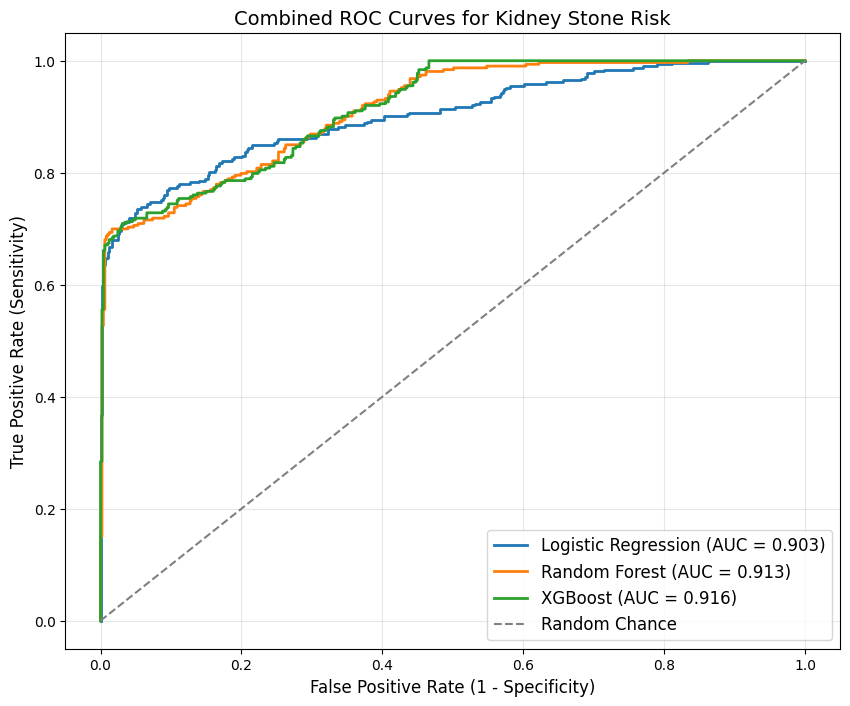

In [27]:
# Cell 10: Plot Combined ROC Curves

plt.figure(figsize=(10, 8))

for name, model in best_estimators.items():
    y_prob = model.predict_proba(X_test_final)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

# Plot Random Chance Line
plt.plot([0, 1], [0, 1], 'k--', linestyle='--', color='gray', label='Random Chance')

# Aesthetics
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Combined ROC Curves for Kidney Stone Risk', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

--- Table 1: Descriptive Statistics by Stone Risk ---


stone_risk                      0            1
blood_pressure count  2433.000000  1567.000000
               mean    105.575696   140.696479
               std       9.738953    25.650077
               min      90.019471    90.055729
               25%      97.803470   115.072027
               50%     105.862771   144.747521
               75%     112.067060   162.410685
               max     177.938796   179.991991
water_intake   count  2433.000000  1567.000000
               mean      2.592193     2.370652
               std       0.572176     0.571539
               min       1.500627     1.503092
               25%       2.105950     1.896887
               50%       2.649585     2.298313
               75%       3.085444     2.815842
               max       3.499595     3.498038

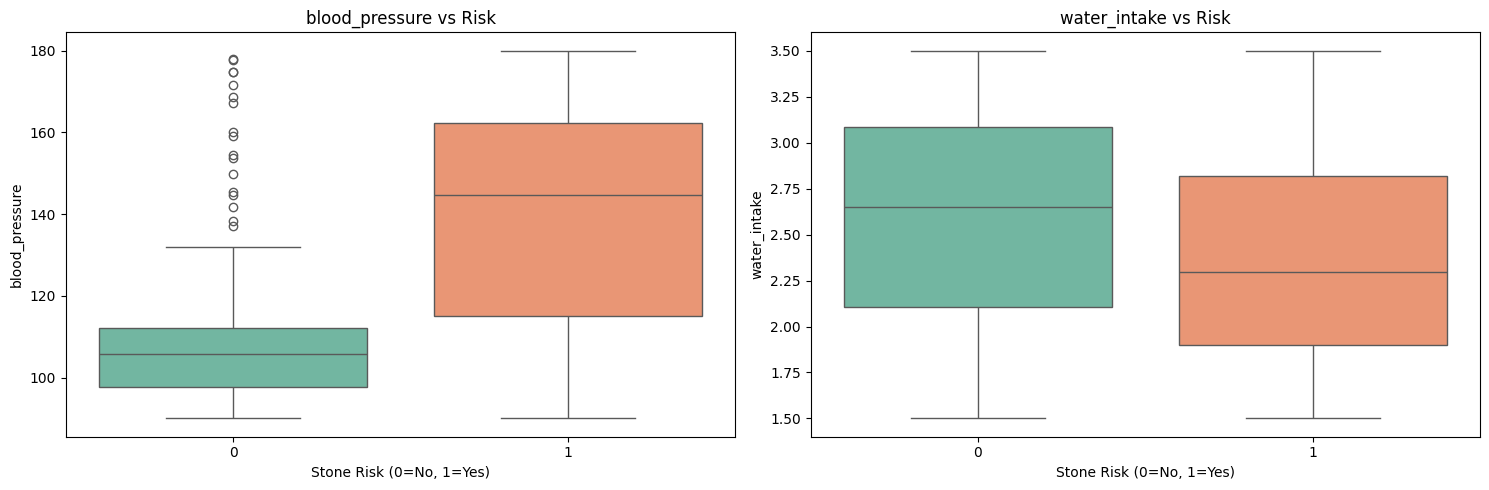

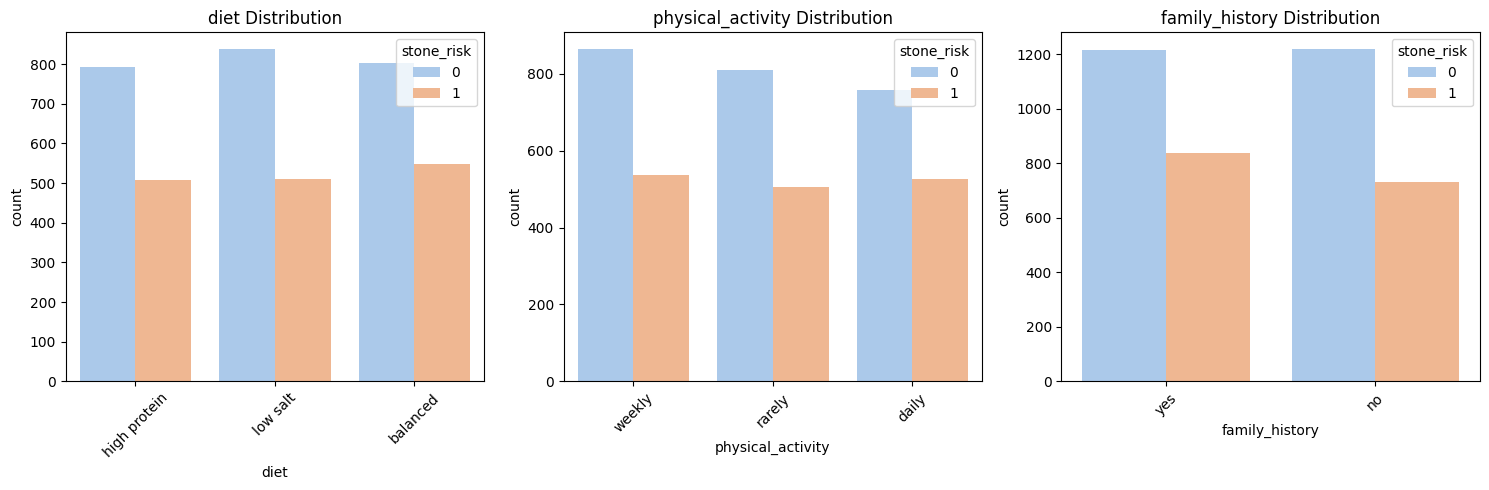

In [28]:
# Cell: EDA - Descriptive Stats and Distributions

# 1. Generate Table 1: Descriptive Statistics
# We separate the data by target to see differences
desc_stats = df.groupby(target)[honest_features].describe().transpose()
print("--- Table 1: Descriptive Statistics by Stone Risk ---")
display(desc_stats)

# 2. Visualize Key Numerical Distributions
# We focus on the numerical honest features
num_cols_eda = df[honest_features].select_dtypes(include=['number']).columns

plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols_eda):
    plt.subplot(1, len(num_cols_eda), i+1)
    sns.boxplot(x=target, y=col, data=df, palette='Set2')
    plt.title(f'{col} vs Risk')
    plt.xlabel('Stone Risk (0=No, 1=Yes)')
plt.tight_layout()
plt.show()

# 3. Visualize Key Categorical Distributions
cat_cols_eda = ['diet', 'physical_activity', 'family_history'] # Select top 3 interesting ones

plt.figure(figsize=(15, 5))
for i, col in enumerate(cat_cols_eda):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=col, hue=target, data=df, palette='pastel')
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

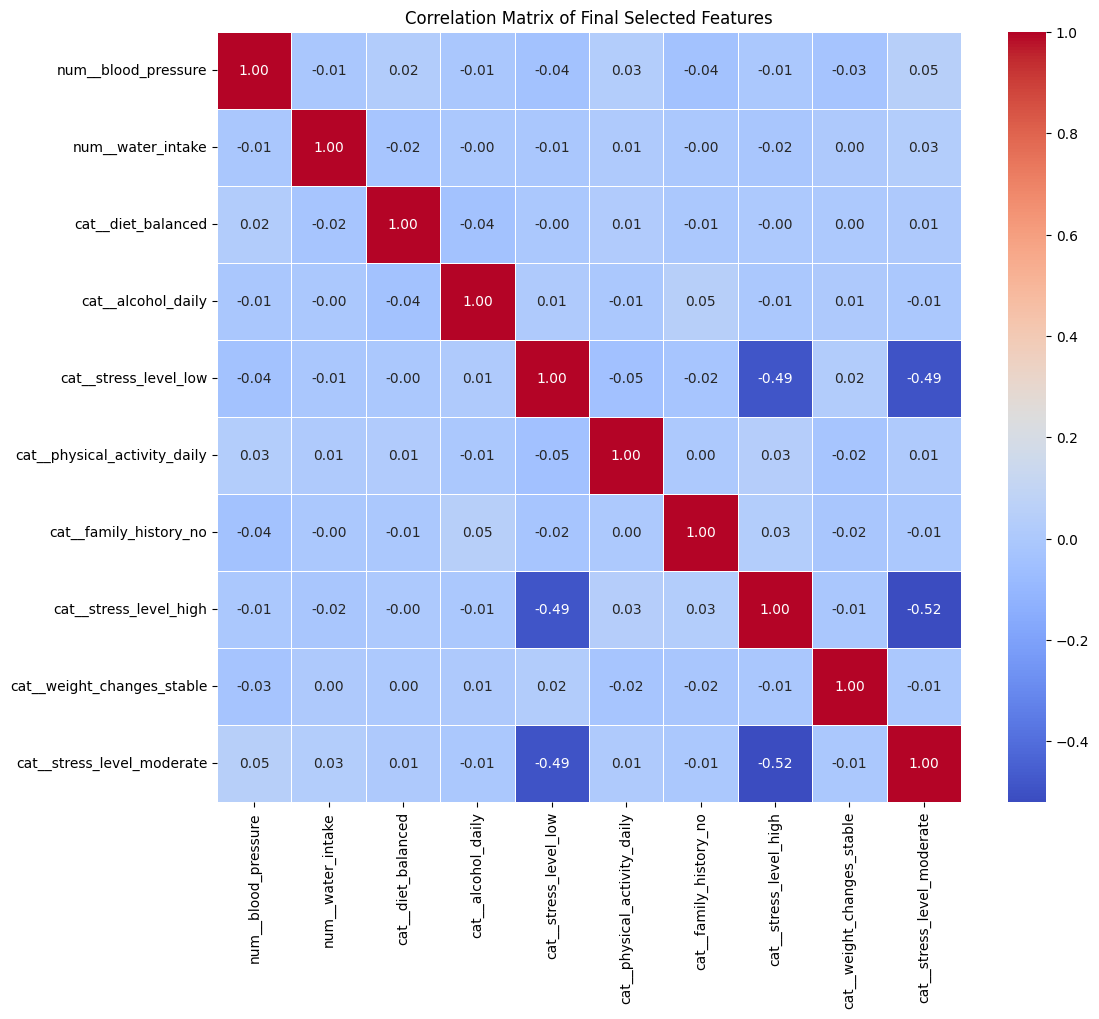

In [29]:
# Cell: Correlation Heatmap of Selected Features

# Reconstruct a DataFrame from the selected final features for visualization
# Note: We use the names of the top features we found in the Feature Selection step
X_train_final_df = pd.DataFrame(X_train_final, columns=top_features_df['Feature'].values)

plt.figure(figsize=(12, 10))
# Calculate correlation matrix
corr_matrix = X_train_final_df.corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Final Selected Features')
plt.show()

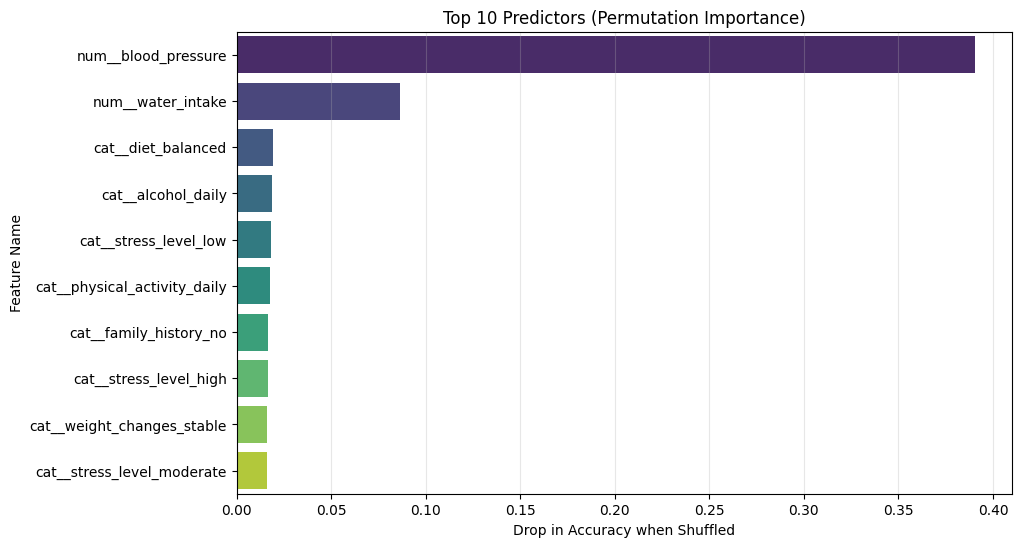

In [30]:
# Cell: Feature Importance Plot

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features_df, palette='viridis')
plt.title('Top 10 Predictors (Permutation Importance)')
plt.xlabel('Drop in Accuracy when Shuffled')
plt.ylabel('Feature Name')
plt.grid(axis='x', alpha=0.3)
plt.show()

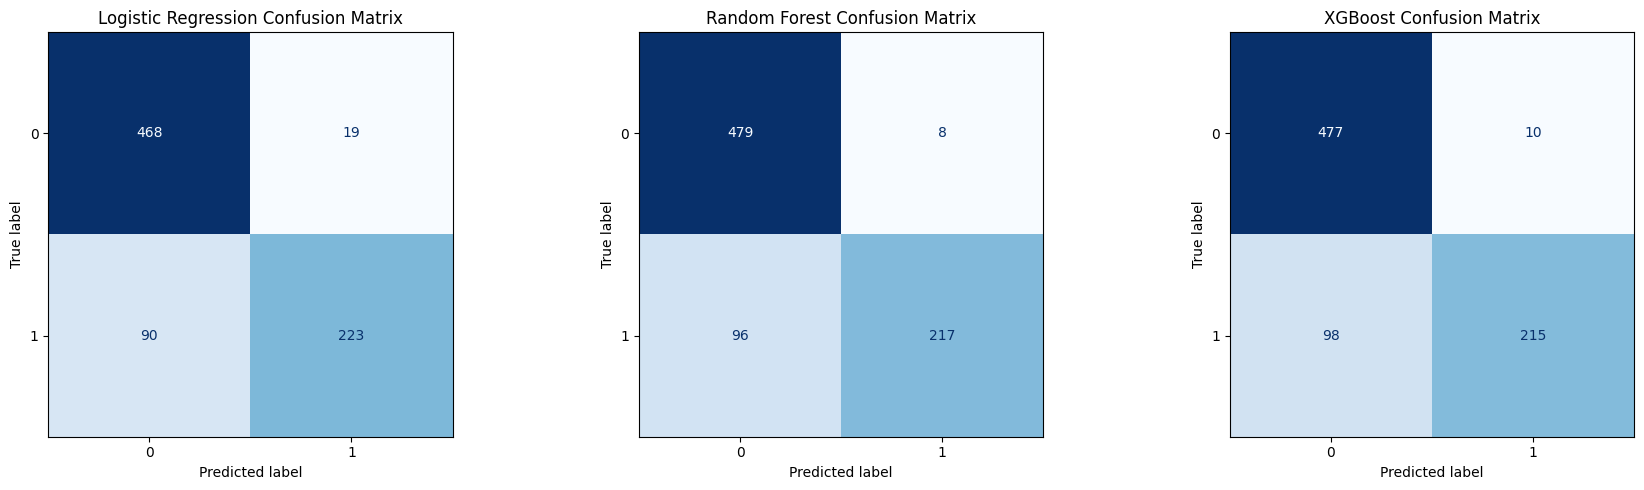

In [31]:
# Cell: Confusion Matrix Comparison
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(best_estimators.items()):
    # Predict on Final Test Set
    y_pred = model.predict(X_test_final)
    
    # Plot
    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred, 
        ax=axes[i], 
        cmap='Blues', 
        colorbar=False
    )
    axes[i].set_title(f'{name} Confusion Matrix')

plt.tight_layout()
plt.show()

Generating SHAP Plot for XGBoost...


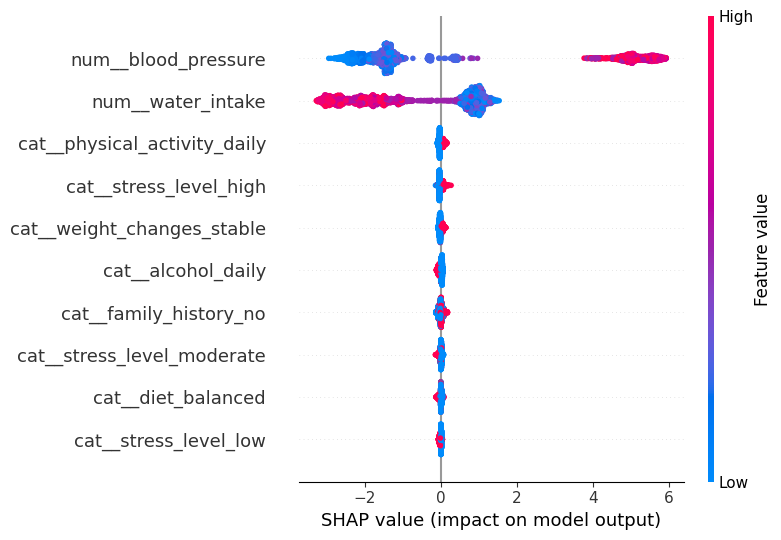

In [32]:
# Cell: SHAP Interpretation
import shap

# 1. Select the best model (assuming XGBoost is usually best, or pick specifically)
best_model_name = 'XGBoost' 
final_model = best_estimators[best_model_name]

# 2. Create SHAP Explainer
# Since we are using XGBoost, we use TreeExplainer
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train_final)

# 3. Generate Summary Plot
print(f"Generating SHAP Plot for {best_model_name}...")
plt.figure()
shap.summary_plot(
    shap_values, 
    X_train_final, 
    feature_names=top_features_df['Feature'].values,
    show=True
)